# Insight Demo
By: Ari Silburt - use "plotting" virtual env

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import utils.processing as proc
import utils.template_match_target as tmt
import utils.transform as tfm

/Users/silburt/anaconda2/envs/plotting/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data

In [2]:
# Load sample of Data
test_imgs = h5py.File('Insight_sample.hdf5', 'r')
Data = {'test': [test_imgs['input_images'][...].astype('float32'),
                 test_imgs['target_masks'][...].astype('float32')]}

# pre-process - normalize image pixels to 1
proc.preprocess(Data)

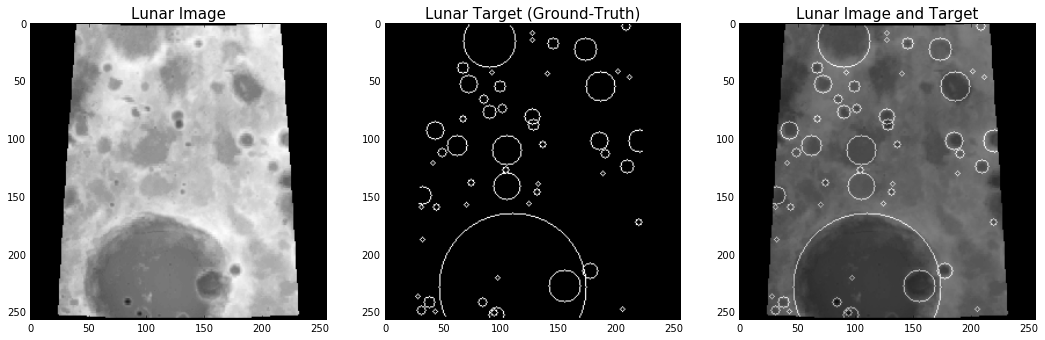

In [3]:
# image number
i=0

# plot 
img = Data['test'][0][i].reshape(256, 256)
target = Data['test'][1][i]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[18, 6])
ax1.imshow(img, origin='upper', cmap='Greys_r')
ax2.imshow(target, origin='upper', cmap='Greys_r')
ax3.imshow(img, origin='upper', cmap='Greys_r')
ax3.imshow(target, origin='upper', cmap='Greys_r', alpha=0.5)
ax1.set_title("Lunar Image", fontsize=15)
ax2.set_title("Lunar Target (Ground-Truth)", fontsize=15)
ax3.set_title("Lunar Image and Target", fontsize=15)

# Generating Predictions From Trained Model Weights

In [4]:
model = load_model('model_keras1.2.2.h5')

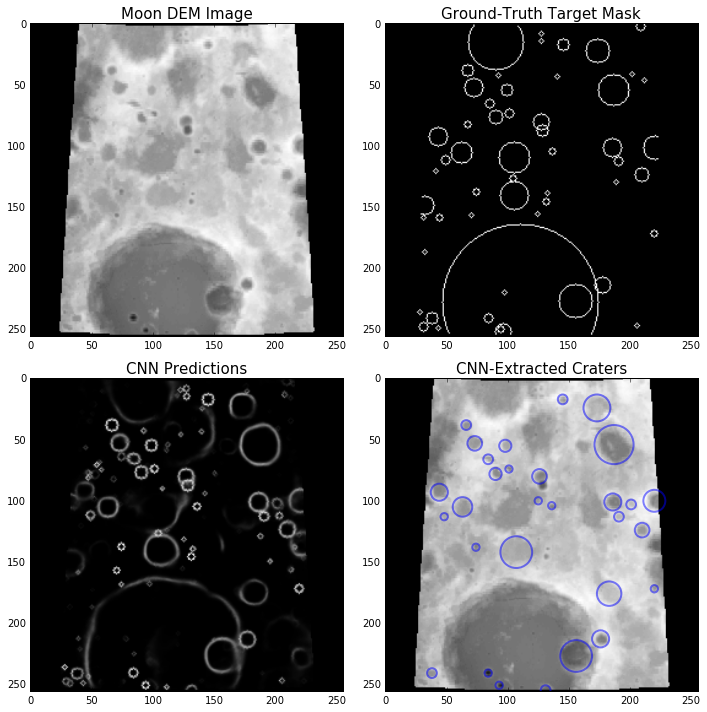

In [5]:
# image number
i=0

# Use the CNN to make a prediction
pred = model.predict(Data['test'][0][i, np.newaxis])
# Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=3.)

# plot
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=[10, 10])
img = Data['test'][0][i].reshape(256, 256)
target = Data['test'][1][i]
ax1.imshow(img, origin='upper', cmap='Greys_r')
ax2.imshow(target, origin='upper', cmap='Greys_r')
ax3.imshow(pred[0], origin='upper', cmap='Greys_r')
ax4.imshow(img, origin='upper', cmap="Greys_r")
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax4.add_artist(circle)
ax1.set_title('Moon DEM Image', fontsize=15)
ax2.set_title('Ground-Truth Target Mask', fontsize=15)
ax3.set_title('CNN Predictions', fontsize=15)
ax4.set_title('CNN-Extracted Craters', fontsize=15)
plt.tight_layout()

# Final Crater Distribution

In [6]:
# Helper Stats Function: Match CNN-extracted craters to ground-truth, get precision recall
def get_stats(CNN_craters, GT_craters, longlat_thresh2=2.6, rad_thresh=1.8):
    N_match, err_lo, err_la, err_r, beta = 0, 0, 0, 0, 1
    N_csv, N_detect = len(GT_craters), len(CNN_craters)
    k2d = 180. / (np.pi * 1737.4)       # km to deg
    N_match = 0
    frac_dupes = 0
    N_csv, N_detect = len(GT_craters), len(CNN_craters)
    matched_craters = np.empty([0, 3])
    for lo, la, r in CNN_craters:
        Long, Lat, Rad = GT_craters.T
        minr = np.minimum(r, Rad)
        la_m = (la + Lat) / 2.

        # check for match between CNN-extracted craters and ground-truth
        dL = (((Long - lo) / (minr * k2d / np.cos(np.pi * la_m / 180.)))**2 + ((Lat - la) / (minr * k2d))**2)
        dR = np.abs(Rad - r) / minr
        index = (dR < rad_thresh) & (dL < longlat_thresh2)
        index_True = np.where(index == True)[0]
        N = len(index_True)
        if N >= 1:
            matched_craters = np.vstack((matched_craters, np.array((lo, la, r))))
            # if multiple matches to ground-truth, count closest as match
            if N > 1: 
                min_index = np.argmin(dL + dR**2)
                for j in range(len(index_True)):
                    if index_True[j] != min_index:
                        index[index_True[j]] = False
        N_match += min(1, N)
        # remove csv(s) so it can't be re-matched again
        GT_craters = GT_craters[np.where(index == False)]
        if len(GT_craters) == 0:
            break
            
    # Print stats
    p = float(N_match) / float(N_match + (N_detect - N_match))
    r = float(N_match) / float(N_csv)
    f = (1 + beta**2) * (r * p) / (p * beta**2 + r)
    print("IMAGE STATS:\nprecision = %.3f\nrecall = %.3f\nf1_score = %.3f\n"
          "new_crater_fraction = %.3f"%(p, r, f, (N_detect - N_match)/float(N_csv)))
    print("--------")
    print("COLOR INFO:\nBlue = Matched Craters\nRed = New Craters\nFuschia = Missed Craters")
    return matched_craters, GT_craters

# Crop craters according to long/lat boundaries
def get_crop(craters, llbd, box, size):
    Lo, La, R =  craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) & 
                         (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])].T
    x, y = tfm.coord2pix(Lo, La, llbd, size)
    r = R / ((llbd[3] - llbd[2]) * (np.pi / 180.0) * (1737.4 / (box[2] - box[0])))
    return np.array(list(zip(x, y, r))), np.array(list(zip(Lo, La, R)))

# Call ground truth
def get_GT():
    C1 = pd.read_csv('catalogues/LROCCraters.csv')  # catalog 1
    C2 = pd.read_csv('catalogues/HeadCraters.csv')  # catalog 2
    C2 = C2[(C2['Lat']>=-60)&(C2['Lat']<=60)&(C2['Lon']>60)&(C2['Diam_km']>20.)]
    C1 = C1[(C1['Lat']>=-60)&(C1['Lat']<=60)&(C1['Long']>60)]
    ra = np.concatenate((C1['Diameter (km)'].values/2.,C2['Diam_km'].values/2.))
    lo = np.concatenate((C1['Long'].values,C2['Lon'].values))
    la = np.concatenate((C1['Lat'].values,C2['Lat'].values))
    return np.column_stack((lo, la, ra))

# Top-level function to crop boundaries of global Lunar (DEM) Image
def crop_craters(craters, img_global, xp, yp, lenp):
    xc = xp * img_global.size[0] / 3. + 2 * img_global.size[0] / 3.
    yc = yp * img_global.size[1]
    rawlen = lenp * img_global.size[0] / 3.
    
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='float32')
    img_crop = img_global.crop(box)
    
    # Crop craters within bounding box, convert to pixel coordinates
    llbd = tfm.pix2coord(box[0::2], box[1::2], [-180., 180., -60., 60.], img_global.size)
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    
    # CNN-extracted and Ground Truth (GT) craters
    craters_pix, craters_llkm = get_crop(craters, llbd, box, img_crop.size)
    GT_pixels, GT_llkm = get_crop(get_GT(), llbd, box, img_crop.size)
    return np.asanyarray(img_crop), craters_pix, craters_llkm, GT_pixels, GT_llkm

IMAGE STATS:
precision = 0.568
recall = 0.944
f1_score = 0.709
new_crater_fraction = 0.718
--------
COLOR INFO:
Blue = Matched Craters
Red = New Craters
Fuschia = Missed Craters


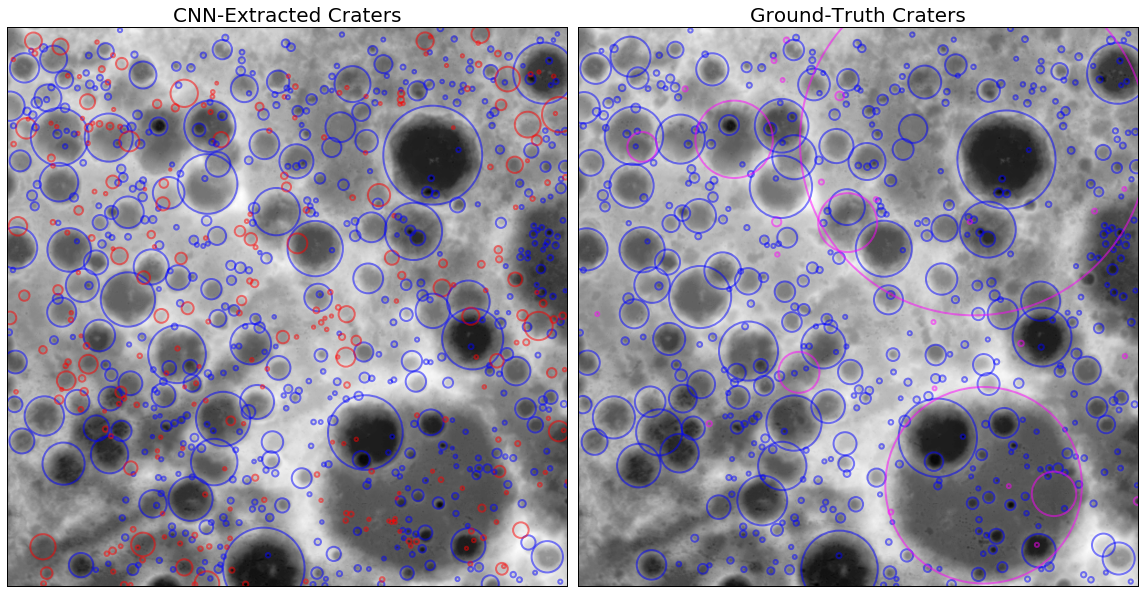

In [7]:
# Dimensions of crop
longp = 0.6     # longitude coordinate as a percentage of Lunar test region (0-1 range)
latp = 0.5      # latitude coordinate as a percentage of Lunar test region (0-1 range)
lenp = 0.2      # length of cropped Lunar test region as a percentage  (0-1 range)

# Load post-processed craters and Global Image of Moon
craters = np.load('post-processed_test_craters.npy')
img_global = Image.open('tests/LunarLROLrocKaguya_1180mperpix_downsamp.png').convert("L")

# Get cropped image of the Moon and corresponding cropped crater catalogue.
img_crop, craters_pix, craters_llkm, GT_pix, GT_llkm = crop_craters(craters, img_global, longp, latp, lenp)

# Match craters to Ground Truth, Detect New Craters
CNN_matched_craters, GT_remain = get_stats(craters_llkm, GT_llkm)

# Plot the cropped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 12])
ax1.imshow(img_crop, cmap='Greys_r', vmin=np.min(img_crop), vmax=np.max(img_crop))
ax2.imshow(img_crop, cmap='Greys_r', vmin=np.min(img_crop), vmax=np.max(img_crop))
ax1.set_title("CNN-Extracted Craters", fontsize=20)
ax1.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
ax2.set_title("Ground-Truth Craters", fontsize=20)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
plt.tight_layout()

# Plot cropped CNN-extracted craters
for k in range(len(craters_pix)):
    color = 'blue'
    if craters_llkm[k] not in CNN_matched_craters:
        color = 'red'
    x, y, r = craters_pix[k].T
    circle = plt.Circle((x, y), r, color=color, fill=False, linewidth=2, alpha=0.5)
    ax1.add_artist(circle)
    
# Plot Ground-truth craters
for k in range(len(GT_pix)):
    color = 'blue'
    if GT_llkm[k] in GT_remain:
        color = 'fuchsia'
    GTx, GTy, GTr = GT_pix[k].T
    circle = plt.Circle((GTx, GTy), GTr, color=color, fill=False, linewidth=2, alpha=0.5)
    ax2.add_artist(circle)